In [226]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing all the necessary Packages and Libraries

## Installations

In [227]:
pip install BioPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [228]:
pip install propy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [229]:
pip install pyfaidx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports for peptide feature extraction

In [230]:
# Compute protein descriptors
from propy import PyPro
from propy import AAComposition
from propy import CTD

# Build Sequence Object
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Read Fasta File
from pyfaidx import Fasta

# Grouping iterable
from itertools import chain

# Return file path
import glob

## Imports for ML

In [258]:
# Import necessary packages

import pandas as pd
import numpy as np
import json 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

# Importing data and Extracting the Features

Each individual protein have unique structural and functional properties, we use Biopython (a free biological computational tool) ProteinAnalysis library, to extract all the necessary features from the sequences. 

## Feature Extraction function

In [232]:
# Feature Extraction

def ExtractFeaturesFasta(fastafile):
    
    """ The ExtractFeaturesFasta function gets the protein sequence in the Fasta file format.
    The function parse the fasta file, read the sequence as string and extract the peptide features using appropriate packages into the dataframe.
    
    Parameters
    ----------
    fastafile: File containing peptide sequences in FASTA format
    
    Returns
    -------
    allFeatures: The dataframe with extracted features of each peptide.
    allFeaturesName: A dictionary containing each set of name of the features """
    

    new_peptides = []
    for file in glob.glob(fastafile):
      new_peptides.append(file)
    
    for f in new_peptides:
        fa = Fasta(f)
        # empty list to save the features
        listing = []
        
        for seq in fa:
            # Make sure the sequence is a string
            s = str(seq)
            
            # replace the unappropriate peptide sequence to A
            s = s.replace('X','A')
            s = s.replace('x','A')
            s = s.replace('U','A')
            s = s.replace('Z','A')
            s = s.replace('B','A')

            # Calculating primary features
            analysed_seq = ProteinAnalysis(s)
            wt = analysed_seq.molecular_weight()
            arm = analysed_seq.aromaticity()
            instab = analysed_seq.instability_index()
            flex = analysed_seq.flexibility()
            pI = analysed_seq.isoelectric_point()

            # Create list for identity of protein - Name and Seq
            pId = [seq.name, s]

            # create a list for the primary features
            pFeatures = [len(seq), wt, arm, instab, pI]

            # Get Amino Acid Composition (AAC), Composition Transition Distribution (CTD) and Dipeptide Composition (DPC)
            resultAAC = AAComposition.CalculateAAComposition(s)
            resultCTD = CTD.CalculateCTD(s)
            resultDPC = AAComposition.CalculateDipeptideComposition(s)

            # Collect all the features into lists
            aacFeatures = [j for i,j in resultAAC.items()]
            ctdFeatures = [l for k,l in resultCTD.items()]
            dpcFeatures = [n for m,n in resultDPC.items()]
            listing.append(pId + pFeatures + aacFeatures + ctdFeatures + dpcFeatures)
            
        # Collect feature names
        IDname = ['Name','Seq']
        Pname = ['SeqLength','Weight','Aromaticity','Instability','IsoelectricPoint']
        AACname = [i for i,j in resultAAC.items()]
        CTDname = [k for k,l in resultCTD.items()]
        DPCname = [m for m,n in resultDPC.items()]
        feature_names  = []
        feature_names.append(IDname+Pname+AACname+DPCname+CTDname)
        flatten_list = list(chain.from_iterable(feature_names))

        # create dataframe using all extracted features and the names
        allFeatures = pd.DataFrame(listing, columns = flatten_list)

        # creating dictionary containing all set of name of the features
        allFearuresName = {'primary':Pname, 'AAC':AACname, 'CTD':CTDname, 'DPC':DPCname}
       

        return allFeatures, allFearuresName


In [233]:
negativeDf, negativeFeatureNames = ExtractFeaturesFasta('/content/drive/Shareddrives/Interview Prep/proteins/negative.fasta')

print('\n')
print('The shape of the negative peptide dataframe')
print('Number of rows:    ', negativeDf.shape[0])
print('Number of columns: ', negativeDf.shape[1])

pd.set_option('display.max_columns', None)
negativeDf.head()



The shape of the negative peptide dataframe
Number of rows:     2746
Number of columns:  574


Name  \
0  sp|A0A0P0VIP0|LRSK7_ORYSJ   
1  sp|A0A0P0XII1|CERK1_ORYSJ   
2      sp|A2ZVI7|CDPK1_ORYSJ   
3      sp|A3BMZ5|BGL26_ORYSJ   
4      sp|B1Q3J6|DNM1B_ORYSJ   

                                                 Seq  SeqLength       Weight  \
0  MPPRCRRLPLLFILLLAVRPLSAAAASSIAAAPASSYRRISWASNL...        695   74134.0302   
1  MEASTSLLVLVLAAAAFAAGTVTEAAGDGCSAGCDLALASFYVTPN...        624   67067.5347   
2  MGNRTSRHHRAAPEQPPPQPKPKPQPQQQQQQWPRPQQPTPPPAAA...        518   58739.0334   
3  MRKFIAALRLALAAAAHLLLTLPPAQCYWLNPEIYDAGGLSRRAFP...        510   58497.5243   
4  MVKSPCSPVTTGKKRCRAKPQKKDEDTTDKGKLDEGPLDATKEMNG...       1529  171906.4665   

   Aromaticity  Instability  IsoelectricPoint       A      R      N      D  \
0     0.073381    54.427353          9.501624  11.511  8.058  3.309  4.317   
1     0.091346    36.497788          5.450882  10.096  3.846  4.968  4.327   
2     0.075290    46.398842          6.054399   8.108  7.336  3.282  6.950   
3     0.156863    30.562176          7.202205   8.824  5.686  5.098  6.667   
4     0.085023    42.373604          5.846368   7.325  5.363  4.447  6.475   

       C      E      Q      G      H      I       L      K      M      F  \
0  1.295  3.453  1.151  8.489  2.302  2.014  11.223  1.871  2.014  3.741   
1  1.282  4.968  2.564  8.654  1.282  5.449   9.776  3.846  2.244  3.365   
2  0.772  8.494  3.282  6.371  3.668  5.985   7.722  6.178  3.282  4.054   
3  0.980  4.118  2.549  7.843  2.549  5.686   6.863  5.098  2.549  5.294   
4  2.485  8.241  3.663  6.409  1.439  5.232   7.587  8.110  2.354  4.186   

       P      S      T      W      Y      V     AA     AR     AN     AD  \
0  8.921  9.353  4.892  1.295  2.302  8.489  0.386  0.399  0.216  0.481   
1  4.968  8.494  6.250  0.481  5.288  7.853  0.378  0.418  0.204  0.470   
2  5.985  5.405  4.247  0.965  2.510  5.405  0.311  0.409  0.280  0.394   
3  5.098  5.098  4.314  2.745  7.647  5.294  0.327  0.357  0.316  0.435   
4  4.971  7.129  3.859  1.308  3.009  6.409  0.312  0.430  0.258  0.409   

      AC     AE     AQ     AG     AH     AI     AL     AK     AM     AF  \
0  0.222  0.298  0.416  0.240  0.344  0.099  0.823  0.078  0.324  0.432   
1  0.245  0.285  0.386  0.300  0.314  0.077  0.830  0.093  0.357  0.385   
2  0.355  0.251  0.481  0.239  0.280  0.135  0.710  0.154  0.307  0.301   
3  0.292  0.273  0.382  0.320  0.298  0.108  0.784  0.108  0.371  0.312   
4  0.363  0.228  0.441  0.265  0.294  0.135  0.718  0.147  0.326  0.297   

      AP     AS     AT     AW     AY     AV     RA     RR     RN     RD  \
0  0.245  0.488  0.296  0.216  0.222  0.478  0.301  0.288  0.150  0.159   
1  0.258  0.441  0.356  0.204  0.245  0.450  0.304  0.313  0.149  0.191   
2  0.392  0.378  0.342  0.280  0.355  0.363  0.282  0.244  0.170  0.224   
3  0.318  0.388  0.296  0.316  0.292  0.414  0.294  0.242  0.206  0.224   
4  0.377  0.387  0.356  0.258  0.363  0.341  0.296  0.253  0.154  0.226   

      RC     RE     RQ     RG     RH     RI     RL     RK     RM     RF  \
0  0.202  0.256  0.122  0.213  0.274  0.147  0.131  0.014  0.127  0.265   
1  0.236  0.242  0.154  0.217  0.233  0.197  0.124  0.013  0.154  0.266   
2  0.273  0.197  0.176  0.203  0.282  0.132  0.195  0.041  0.215  0.180   
3  0.234  0.238  0.157  0.222  0.212  0.214  0.155  0.029  0.163  0.250   
4  0.307  0.196  0.157  0.225  0.253  0.156  0.198  0.029  0.202  0.191   

      RP     RS     RT     RW     RY     RV     NA     NR     NN      ND  \
0  0.160  0.184  0.285  0.187  0.121  0.192  0.133  0.278  2.446  19.568   
1  0.207  0.189  0.292  0.173  0.167  0.225  0.165  0.283  0.481  21.955   
2  0.242  0.222  0.255  0.213  0.182  0.244  0.205  0.193  0.386  26.255   
3  0.244  0.179  0.246  0.246  0.185  0.232  0.159  0.267  1.176  22.157   
4  0.257  0.211  0.267  0.194  0.187  0.240  0.224  0.208  0.262  23.022   

       NC      NE      NQ     NG      NH      NI      NL       NK     NM  \
0  44.173  71.655  99.712  0.288  28.489  50.072  75.108   99.856  0.144   
1  44.231  

In [234]:
positiveDf, positiveFeatureNames = ExtractFeaturesFasta('/content/drive/Shareddrives/Interview Prep/proteins/positive.fasta')

print('\n')
print('The shape of the negative peptide dataframe')
print('Number of rows:    ', positiveDf.shape[0])
print('Number of columns: ', positiveDf.shape[1])

positiveDf.head()



The shape of the negative peptide dataframe
Number of rows:     448
Number of columns:  574


Name                                                Seq  \
0  sp|Q15746.4|MYLK_HUMAN  MGDVKLVASSHISKTSLSVDPSRVDSMPLTEAPAFILPPRNLCIKE...   
1  sp|Q05655.2|KPCD_HUMAN  MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...   
2  sp|Q09JW6.1|KUNI_ARGMO  MRLLALFAFAVAVVSAQRNQMCQQPRTQGSCDASNQITKFFYTGSG...   
3  sp|P07996.2|TSP1_HUMAN  MGLAWGLGVLFLMHVCGTNRIPESGGDNSVFDIFELTGAARKGSGR...   
4  sp|Q7SZN0.1|FA5V_PSETE  MGRYSVSPVPKCLLLMFLGWSGLKYYQVNAAQLREYHIAAQLEDWD...   

   SeqLength       Weight  Aromaticity  Instability  IsoelectricPoint      A  \
0       1914  210712.6252     0.059039    46.071583          5.854723  6.844   
1        676   77504.1833     0.110947    42.472204          7.933624  5.769   
2        144   15351.4655     0.083333    53.282708          4.301143  7.639   
3       1170  129381.4157     0.075214    42.026419          4.713794  4.444   
4       1460  165930.3940     0.109589    37.376726          5.733713  5.205   

       R      N       D      C      E      Q       G      H      I      L  \
0  5.068  3.292   5.172  2.508  8.777  4.911   7.001  1.567  3.918  7.210   
1  4.882  4.290   5.917  3.107  7.249  3.846   6.657  2.811  5.769  8.432   
2  4.861  3.472   5.556  8.333  8.333  6.944  11.806  1.389  2.778  2.083   
3  5.128  6.923  11.197  5.983  4.359  4.274   8.974  2.308  3.846  5.470   
4  3.904  4.658   6.096  1.096  7.055  3.699   6.712  2.808  6.507  7.740   

       K      M      F      P      S      T      W      Y      V     AA  \
0  7.576  1.620  2.874  6.479  8.673  5.852  1.358  1.672  7.628  0.335   
1  8.728  2.663  6.805  3.550  5.473  4.438  1.331  2.959  5.325  0.283   
2  0.694  1.389  4.167  4.167  9.722  8.333  0.000  4.167  4.167  0.431   
3  4.701  1.197  2.991  5.983  6.325  5.214  1.880  2.650  6.154  0.362   
4  6.986  1.986  4.041  4.932  7.945  5.685  2.192  4.726  6.027  0.316   

      AR     AN     AD     AC     AE     AQ     AG     AH     AI     AL  \
0  0.447  0.217  0.393  0.348  0.259  0.436  0.258  0.306  0.126  0.734   
1  0.416  0.302  0.432  0.349  0.219  0.444  0.297  0.259  0.136  0.732   
2  0.403  0.167  0.410  0.299  0.292  0.333  0.319  0.347  0.056  0.806   
3  0.430  0.209  0.397  0.366  0.237  0.319  0.287  0.394  0.098  0.746   
4  0.417  0.266  0.395  0.324  0.281  0.394  0.303  0.303  0.109  0.760   

      AK     AM     AF     AP     AS     AT     AW     AY     AV     RA  \
0  0.139  0.288  0.348  0.364  0.425  0.357  0.217  0.348  0.381  0.271   
1  0.132  0.364  0.259  0.377  0.349  0.349  0.302  0.349  0.317  0.334   
2  0.139  0.271  0.417  0.312  0.556  0.278  0.167  0.299  0.472  0.229   
3  0.156  0.302  0.309  0.389  0.481  0.310  0.209  0.366  0.359  0.275   
4  0.132  0.343  0.305  0.352  0.377  0.357  0.266  0.324  0.380  0.296   

      RR     RN     RD     RC     RE     RQ     RG     RH     RI     RL  \
0  0.298  0.148  0.183  0.293  0.228  0.167  0.230  0.281  0.148  0.191   
1  0.249  0.176  0.279  0.316  0.170  0.136  0.259  0.243  0.167  0.199   
2  0.329  0.112  0.091  0.238  0.224  0.196  0.273  0.196  0.161  0.105   
3  0.310  0.147  0.175  0.298  0.200  0.163  0.192  0.222  0.236  0.141   
4  0.265  0.168  0.206  0.258  0.232  0.171  0.236  0.240  0.171  0.163   

      RK     RM     RF     RP     RS     RT     RW     RY     RV     NA  \
0  0.029  0.198  0.198  0.222  0.252  0.302  0.190  0.141  0.263  0.197   
1  0.041  0.176  0.190  0.283  0.193  0.244  0.234  0.221  0.215  0.237   
2  0.007  0.217  0.224  0.175  0.259  0.266  0.133  0.070  0.287  0.147   
3  0.033  0.230  0.211  0.231  0.229  0.301  0.189  0.133  0.265  0.195   
4  0.030  0.169  0.221  0.250  0.209  0.273  0.198  0.176  0.239  0.191   

      NR     NN      ND      NC      NE       NQ     NG      NH      NI  \
0  0.205  0.104  24.347  49.060  72.518   99.739  0.209  25.444  49.007   
1  0.215  0.296  25.592  49.112  74.408  100.000  0.444  23.373  48.521   
2  0.210  3.472  30.556  49.306  74.306  100.000  2.083  19.444  50.000   
3  0.218  0.171  25.043  51.624  75.897  

In [235]:
# check if both dataframes have same feature names
if negativeFeatureNames == positiveFeatureNames:
  print('True')
  featureNames = negativeFeatureNames

True


Add Target column 'Class' for both positive and negative data. Combing positive and negative in a single dataset

In [236]:
# Adding Target column
negativeDf['Class'] = 0
positiveDf['Class'] = 1

# Concatenate both dataframes
peptideDf = pd.concat([negativeDf, positiveDf])

# Shuffling the dataframes
peptideDf = peptideDf.sample(frac=1, random_state=1)
peptideDf.head()

Name  \
121   XP_042836648.1angiopoietin-4[Pantheratigris]   
165                           sp|P0C1U4|GUN9_ORYSJ   
1787                        tr|Q0DUK4|Q0DUK4_ORYSJ   
103            pdb|7AHU|EChainE,CoagulationfactorX   
1336                tr|A0A0P0V7L8|A0A0P0V7L8_ORYSJ   

                                                    Seq  SeqLength  \
121   MLPQPAMLLGGLLLAAAAVTAAQRRGQEAAGRRRTHRVQHGQCSYT...        499   
165   MSMYGRDPWGGPLEICHDSATDDDRSRNLDLDRGALSRTLDETQQS...        619   
1787  MAREQALLLTEIVNRGVEPSGPDAGSPTFSVRVRRRLPDFLQSVNL...        542   
103   IVGGQECKDGECPWQALLINEENEGFCGGTILSEFYILTAAHCLYQ...        241   
1336  FYKLLIDNVEELLPVVYTPTVGEACQKYGSIFSRPQGLYISLKEKG...        469   

          Weight  Aromaticity  Instability  IsoelectricPoint       A      R  \
121   55974.4635     0.066132    45.129459          9.093282   9.218  8.818   
165   68367.9981     0.119548    34.687431          9.241301   9.693  5.170   
1787  60108.4515     0.097786    48.080812          9.249940  11.070  8.856   
103   27161.7127     0.099585    38.032822          8.519062   5.809  6.224   
1336  51409.2436     0.093817    37.129467          6.367297   9.168  3.838   

          N      D      C      E       Q      G      H      I       L      K  \
121   5.210  2.405  1.603  6.814  10.020  8.216  2.605  1.403  12.625  2.004   
165   4.523  5.654  1.454  2.746   2.423  9.532  2.908  3.231   8.239  5.977   
1787  2.768  5.166  2.030  4.982   2.030  7.011  2.214  3.690  10.148  3.875   
103   2.905  4.564  3.734  7.884   3.734  9.544  2.075  5.394   5.809  7.884   
1336  3.838  3.625  1.279  7.036   4.051  8.529  1.919  5.970  10.448  6.183   

          M      F      P      S      T      W      Y      V     AA     AR  \
121   2.405  2.204  3.206  6.613  4.810  1.804  2.605  5.411  0.313  0.463   
165   2.262  4.200  6.947  6.624  4.523  2.585  5.170  6.139  0.360  0.357   
1787  2.214  5.166  4.797  8.118  3.137  1.292  3.321  8.118  0.345  0.386   
103   2.075  4.979  2.905  4.564  8.299  1.660  3.320  6.639  0.328  0.390   
1336  1.066  4.264  4.691  6.397  5.117  0.853  4.264  7.463  0.328  0.448   

         AN     AD     AC     AE     AQ     AG     AH     AI     AL     AK  \
121   0.224  0.425  0.353  0.222  0.545  0.198  0.257  0.108  0.800  0.092   
165   0.283  0.451  0.265  0.284  0.394  0.273  0.333  0.111  0.805  0.084   
1787  0.269  0.485  0.277  0.238  0.454  0.268  0.279  0.127  0.771  0.101   
103   0.282  0.436  0.332  0.232  0.415  0.340  0.245  0.141  0.734  0.124   
1336  0.224  0.480  0.286  0.235  0.437  0.292  0.271  0.100  0.793  0.107   

         AM     AF     AP     AS     AT     AW     AY     AV     RA     RR  \
121   0.301  0.321  0.379  0.361  0.415  0.224  0.353  0.373  0.275  0.275   
165   0.333  0.373  0.294  0.444  0.273  0.283  0.265  0.454  0.281  0.244   
1787  0.360  0.341  0.299  0.413  0.317  0.269  0.277  0.397  0.327  0.270   
103   0.336  0.311  0.353  0.394  0.324  0.282  0.332  0.365  0.303  0.246   
1336  0.356  0.339  0.305  0.388  0.388  0.224  0.286  0.401  0.313  0.299   

         RN     RD     RC     RE     RQ     RG     RH     RI     RL     RK  \
121   0.110  0.213  0.325  0.183  0.141  0.215  0.241  0.104  0.163  0.022   
165   0.189  0.194  0.209  0.241  0.157  0.227  0.251  0.178  0.176  0.018   
1787  0.187  0.185  0.274  0.220  0.126  0.233  0.248  0.152  0.189  0.022   
103   0.212  0.208  0.271  0.200  0.158  0.279  0.200  0.175  0.225  0.037   
1336  0.150  0.214  0.256  0.233  0.130  0.252  0.233  0.169  0.150  0.019   

         RM     RF     RP     RS     RT     RW     RY     RV     NA     NR  \
121   0.163  0.169  0.261  0.217  0.273  0.124  0.199  0.237  0.229  0.173   
165   0.128  0.239  0.183  0.202  0.233  0.241  0.142  0.231  0.134  0.249   
1787  0.144  0.231  0.222  0.192  0.250  0.226  0.146  0.214  0.185  0.257   
103   0.188  0.225  0.212  0.225  0.242  0.250  0.171  0.246  0.183  0.237   
1336  0.169  0.267  0.192  0.194  0.310  0.186  0.177  0.231  0.156  0.274   


In [237]:
classes, freq = np.unique(peptideDf['Class'], return_counts=True)

print(f'The class {classes[0]} contains {freq[0]} samples')
print(f'The class {classes[1]} contains {freq[1]} samples')

print(f'The ratio of negative and positive: {round(freq[0]/freq[1],2)} : {freq[1]/freq[1]}')

The class 0 contains 2746 samples
The class 1 contains 448 samples
The ratio of negative and positive: 6.13 : 1.0


We can see that we have more negatives than the positives. The negatives are 6 times the positives.

# EDA

In [238]:
# Checking for null values
peptideDf.isnull().values.any()

False

No null values in the data

In [239]:
# Statistics Summary
peptideDf.describe()

SeqLength        Weight  Aromaticity  Instability  IsoelectricPoint  \
count   3194.000000  3.194000e+03  3194.000000  3194.000000       3194.000000   
mean     449.299624  4.930263e+04     0.084397    39.553625          6.875298   
std      370.085565  4.159641e+04     0.024555     9.144203          1.547372   
min       10.000000  1.191241e+03     0.000000    -8.366667          4.050028   
25%      308.000000  3.321151e+04     0.067073    33.940940          5.641350   
50%      373.000000  4.066725e+04     0.081871    38.966815          6.360022   
75%      508.000000  5.685301e+04     0.099811    44.386734          8.392688   
max    10509.000000  1.209269e+06     0.188450   121.836364         11.999968   

                 A            R            N            D            C  \
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000   
mean      9.879569     5.769299     3.828360     5.791695     2.160738   
std       3.519950     1.918279     1.494536     1.598516     1.452036   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.308000     4.558000     2.845000     4.858000     1.351000   
50%       9.586000     5.638000     3.696500     5.726000     1.907000   
75%      12.268000     6.914750     4.682000     6.769000     2.574000   
max      33.333000    20.853000    11.724000    17.143000    16.901000   

                 E            Q            G            H            I  \
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000   
mean      5.430976     3.205938     8.214069     2.313183     4.423226   
std       2.274371     1.531463     2.038239     0.964460     1.679058   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.072500     2.225750     6.914500     1.636000     3.135250   
50%       5.436000     2.995000     8.171000     2.262000     4.423000   
75%       6.667000     3.855750     9.415500     2.955250     5.556000   
max      40.000000    11.111000    21.053000     6.897000    16.667000   

                 L            K            M            F            P  \
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000   
mean      8.808820     4.796895     2.337300     4.014405     5.104521   
std       2.007165     2.257085     0.943521     1.336759     1.823277   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.571500     3.226000     1.761500     3.153000     4.007750   
50%       8.804000     4.647500     2.278000     3.892500     4.867000   
75%      10.061000     6.088750     2.907000     4.751000     5.846000   
max      19.453000    30.769000     8.148000    13.158000    17.391000   

                 S            T            W            Y            V  \
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000   
mean      7.202090     5.019149     1.366328     3.058985     7.274470   
std       2.053646     1.561996     0.913537     1.367659     2.091602   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.806000     4.076000     0.658250     2.075250     6.010750   
50%       6.980000     4.851000     1.220000     2.869500     7.270500   
75%       8.333000     5.767000     1.926000     3.955000     8.547000   
max      18.018000    24.390000     8.421000     7.736000    16.667000   

                AA           AR           AN           AD           AC  \
count  3194.000000  3194.000000  3194.000000  3194.000000  3194.000000   
mean      0.361065     0.402363     0.236575     0.461418     0.288229   
std       0.049887     0.038245     0.036169     0.047659     0.041659   
min       0.000000     0.276000     0.077000     0.233000     0.152000   
25%       0.327000     0.378000     0.213000     0.430000     0.261000   
50%       0.359000     0.402000     0.237000     0.464000     0.284000   
75%       0.396000     0.426000     0.259000     0.494000     0.311000   
max       0.543000  

## Correlation

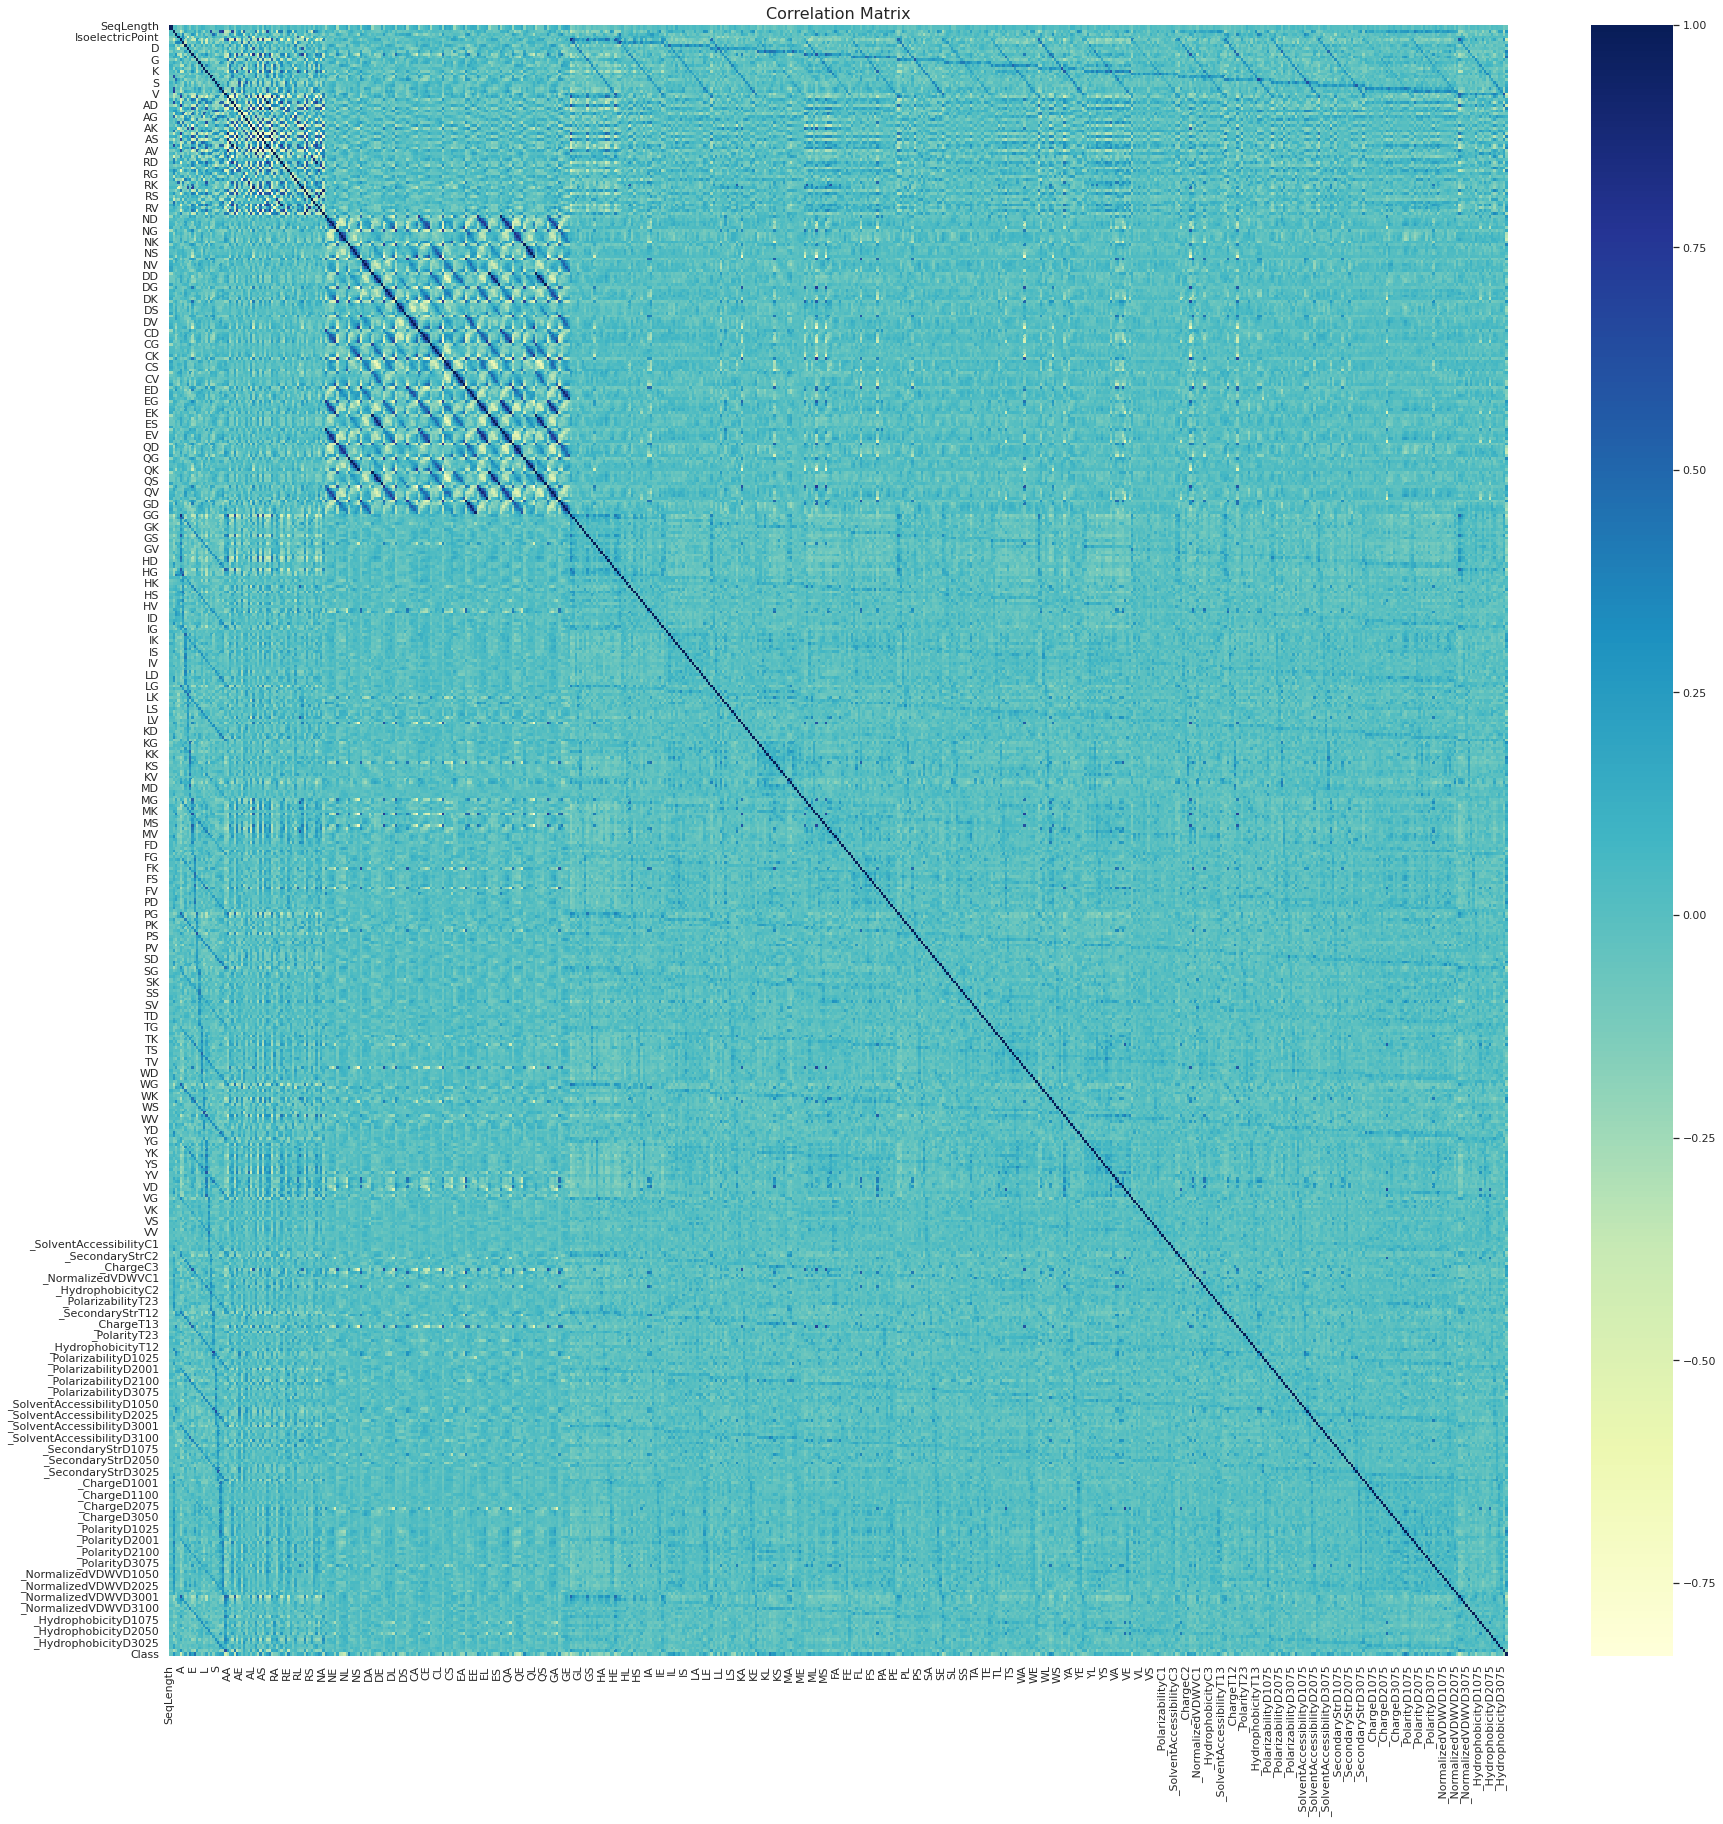

In [240]:
plt.subplots(figsize=(30, 30))
sns.heatmap(peptideDf.corr(), cmap="YlGnBu")

plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [241]:
# Looking at the dictionary containing feature names
for setName in featureNames.keys():
  print(f'{setName:7}:{len(featureNames[setName])}')

primary:5
AAC    :20
CTD    :147
DPC    :400


**Figure 1 - Correlation Matrix of All features**

*Observation*
- Since we have large number of features it is difficult to visualize the correlation. But we can see two square patterns in correlation of features. In any case, let us look at each feature sets separately.

***
[sns.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
[matshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html)



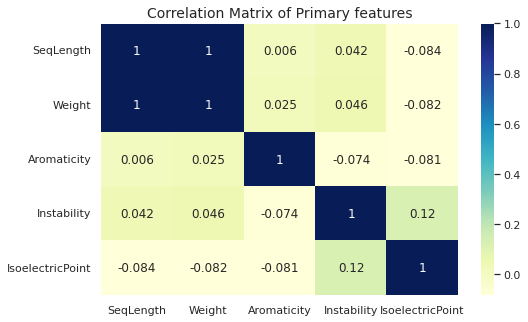

In [242]:
# Plotting Primary features
f = plt.figure(figsize=(8, 5))
sns.heatmap(peptideDf[featureNames['primary']].corr(), cmap="YlGnBu", annot=True)

plt.title('Correlation Matrix of Primary features', fontsize=14);
plt.show()

**Figure 2 - Correlation Matrix of Primary features**

*Observation*
- We can see that the sequence length and weight are highly correlated. This makes sense because increase in sequence length means adding more amino acid which in turn will increase the molecular weight of the protein.
- The correlation between the rest of the features are not more than 10%, this indicates that these features are independent to each other.


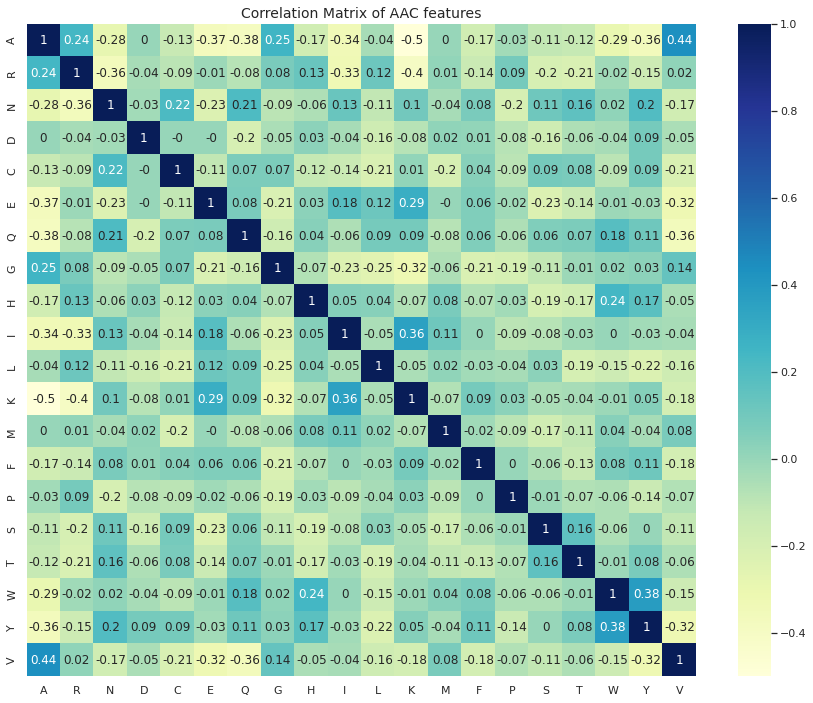

In [243]:
# Plotting Amino Acid Composition features
f = plt.figure(figsize=(15, 12))
sns.heatmap(round(peptideDf[featureNames['AAC']].corr(),2), cmap="YlGnBu", annot=True)    # rounding the correlation values to 2 decimal points

plt.title('Correlation Matrix of AAC features', fontsize=14);
plt.show()

**Figure 3 - Correlation Matrix of Primary features**

*Observation*
- No two features have more than 45% of correlation (on both positive and negative relationship).
- This indicates, in Amino Acid Composition none of the amino acids are highly correlated.

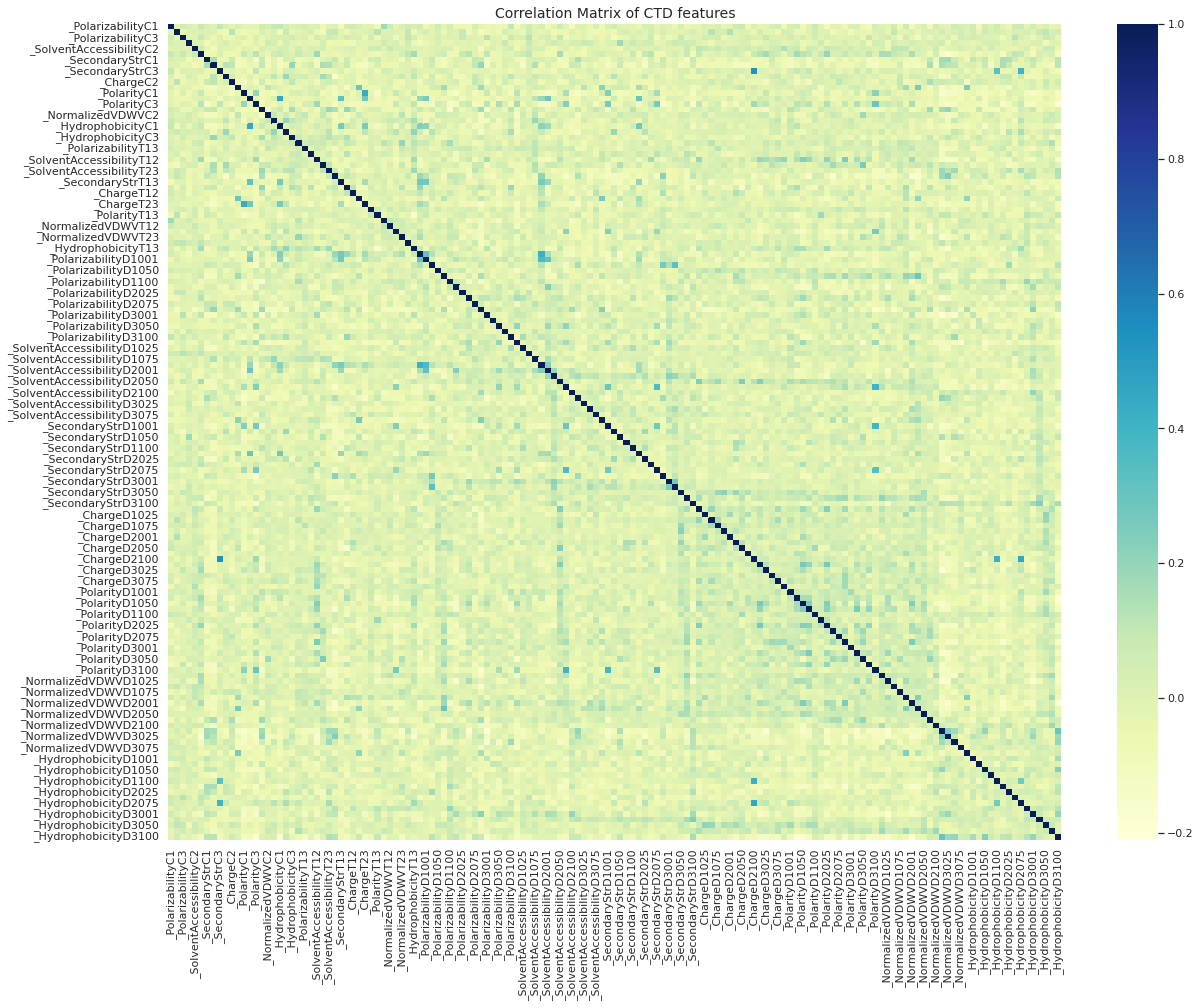

In [244]:
# Plotting Composition Transition and Distribution features
f = plt.figure(figsize=(20, 15))
sns.heatmap(round(peptideDf[featureNames['CTD']].corr(),2), cmap="YlGnBu")    # rounding the correlation values to 2 decimal points

plt.title('Correlation Matrix of CTD features', fontsize=14);
plt.show()

**Figure 3 - Correlation Matrix of Primary features**

*Observation*
- From the correlation matrix it looks like we don't have any highly correlated features.
- As the number of features is high, it is difficult to check for highly correlated features

*Sol: Show only the features with high correlation*

In [245]:
# Get highly correlated features on either side for CTD
highCorrCTD = peptideDf[featureNames['CTD']].corr()
highCorrCTD = highCorrCTD[(abs(highCorrCTD) > 0.9) & (abs(highCorrCTD) != 1)]

if highCorrCTD.notna().values.any() == False:
  print('No two features are highly correlated in CTD')

No two features are highly correlated in CTD


In [246]:
# Get highly correlated features on either side for DPC
highCorrDPC = peptideDf[featureNames['DPC']].corr()
highCorrDPC = highCorrDPC[(abs(highCorrDPC) > 0.9) & (abs(highCorrDPC) != 1)]

if highCorrDPC.notna().values.any() == False:
  print('No two features are highly correlated in DPC')
else:
  print('There are highly correlated features in DPC')

# Get correlation matrix of the selected features table
highCorrDPC = highCorrDPC.where(np.triu(np.ones(highCorrDPC.shape), k=1).astype(bool)).stack().reset_index()
highCorrDPC.rename(columns={'level_0':'feature 1', 'level_1':'feature 2', 0:'Correlation'}, inplace=True)
highCorrDPC

There are highly correlated features in DPC


feature 1 feature 2  Correlation
0         AA        AS     0.905453
1         AC        AP     0.974762
2         AK        RM     0.915821
3         AM        RA     0.904743
4         AF        AS     0.911082
5         AF        AV     0.932718
6         AP        AY     0.974762
7         RD        RY     0.925658
8         RF        NR     0.917585
9         RP        NA     0.924654
10        NN        EW     0.974798
11        NQ        QR     0.917470
12        DN        EM     0.967254
13        DD        EF     0.923523
14        DC        EP     0.935424
15        DE        ES     0.918277
16        DQ        ET     0.966869
17        EN        GN     0.943491
18        ED        GD     0.943409
19        EC        GC     0.921726
20        EQ        GQ     0.936755
21        EH        QY     0.932860
22        EK        QR     0.921832
23        EK        GR     0.947185
24        EM        QM     0.967254
25        EF        QF     0.923523
26        EP        QP     0.935424
27        ES        QS     0.918277
28        ET        QT     0.966869
29        QR        GR     0.943731

[correlation_matrix_transform](https://python-forum.io/thread-15071.html)

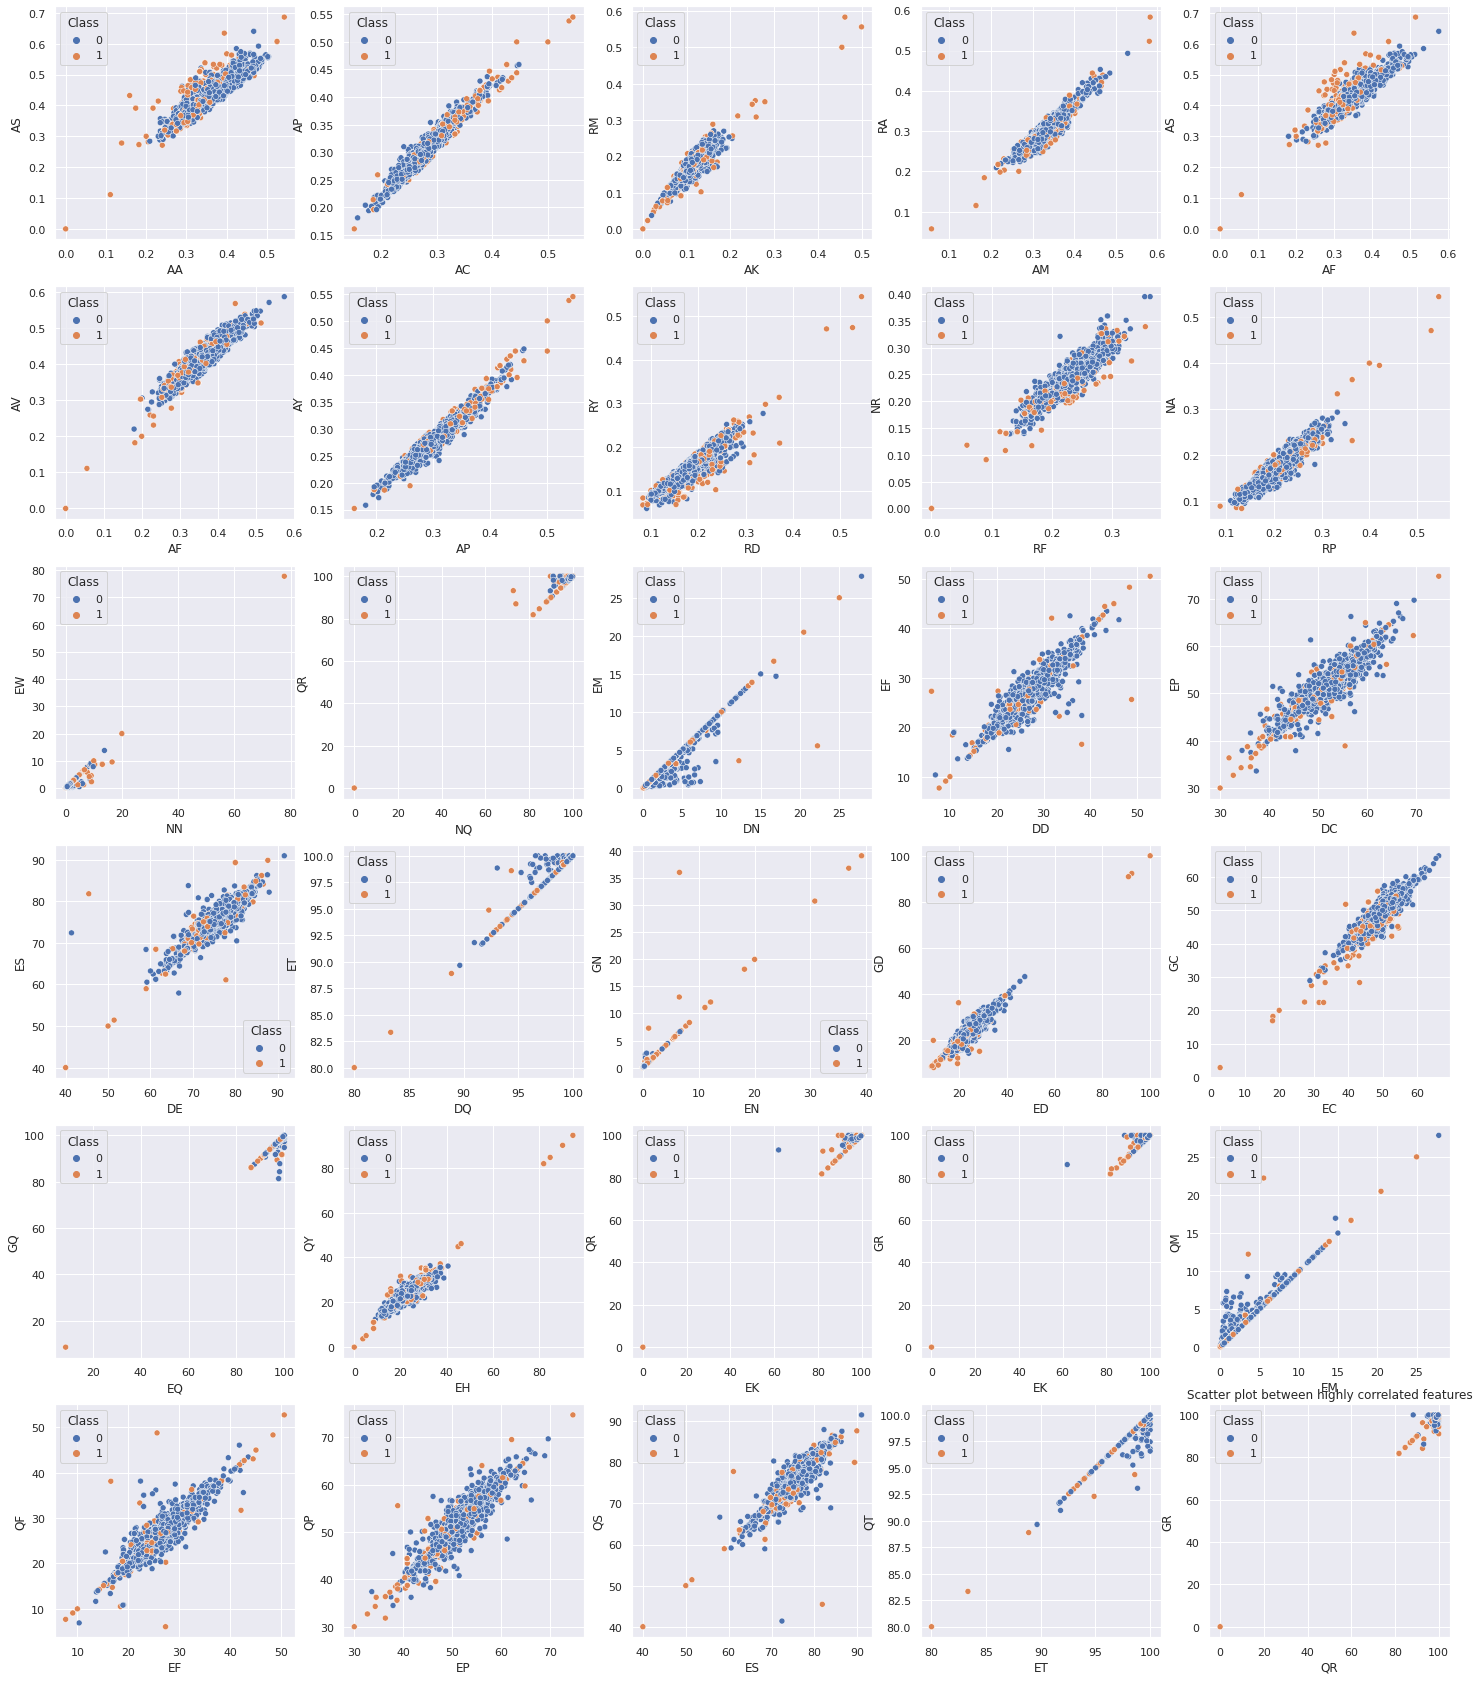

In [247]:
# scatter plot between highly correlated features
ax = []
for i in range(0,6):
    for j in range(0,5):
        ax.append([i,j])

fig, axes = plt.subplots(6,5,figsize=(25,30))
for i in range(30):
  x,y = ax[i]
  sns.scatterplot(data = peptideDf, x=peptideDf[highCorrDPC['feature 1'][i]], y=peptideDf[highCorrDPC['feature 2'][i]], hue = 'Class', ax=axes[x,y])
plt.title('Scatter plot between highly correlated features')
plt.show()

**Figure 4 - Scatter plot between highly correlated DPC features**

*Observation*
- Strongly correlated features are not linearly seperable between the classes.
- Having high correlated features will add more complexity to the model.

*Sol: Remove one of the highly correlated features*

In [248]:
# Saving highly correlated features in json file

corr_features_to_remove = list(highCorrDPC['feature 1'])
corr_features_to_remove.append('Weight')       # Adding Weight

In [249]:
# save the highly correlated features in the json file
with open("/content/drive/Shareddrives/Interview Prep/proteins/corr_features_to_remove.json", "w") as outfile:
    json.dump(corr_features_to_remove, outfile)

In [250]:
# peptideDf = peptideDf.drop(columns=corr_features_to_remove)
# print(peptideDf.shape)

## Distributions

Number of features :  5



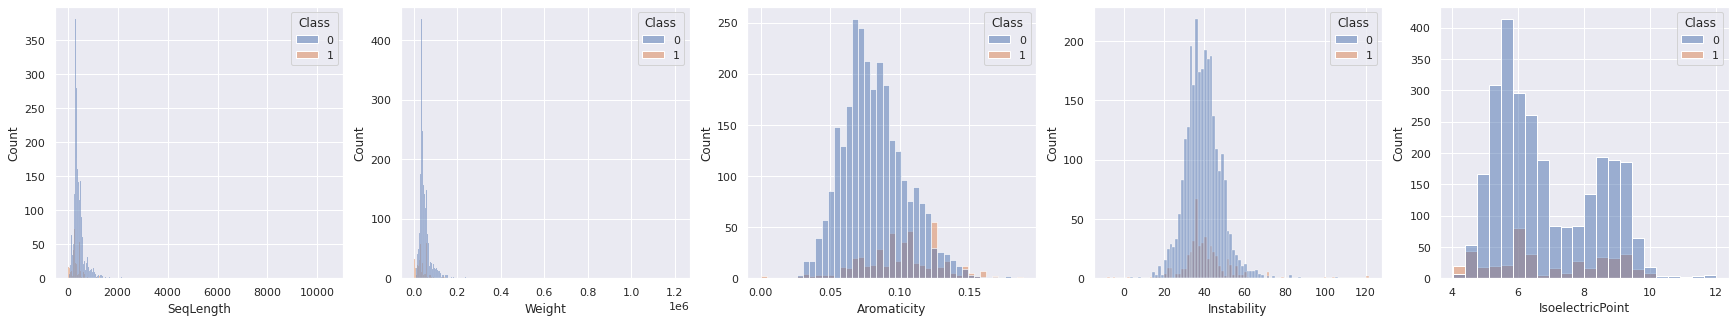

In [252]:
# reset peptideDf index
peptideDf.reset_index(level=0, inplace=True)

# Distribution of primary features
primaryFeatures = featureNames['primary']
length = len(primaryFeatures)
print('Number of features : ',length)
print()

fig, axes = plt.subplots(1,5,figsize=(30,5))
for i in range(length):
  hist = sns.histplot(peptideDf, x=primaryFeatures[i], hue='Class', ax=axes[i])
plt.show()

**Figure 5 - Histogram of primary features for both classes**

*Observation*
- Sequence Length has most of its values below 2000.
- Weight has most of its values below 0.2.
  *Note: Seqlence length and weight are highly correlated thus have similar distributions*
- Aromaticity is normally distributed for both the classes but the centre of positive peptides are shifted slightly towards right.
- Instability is normally distributed for both the classes. Also they are equally centered.
- Isoelectric Point is distributed bimodally.

*Sol: Remove peptides having sequence length above 2000*

[Biomodal Distributions] (https://www.statisticshowto.com/what-is-a-bimodal-distribution/)

Number of features :  20



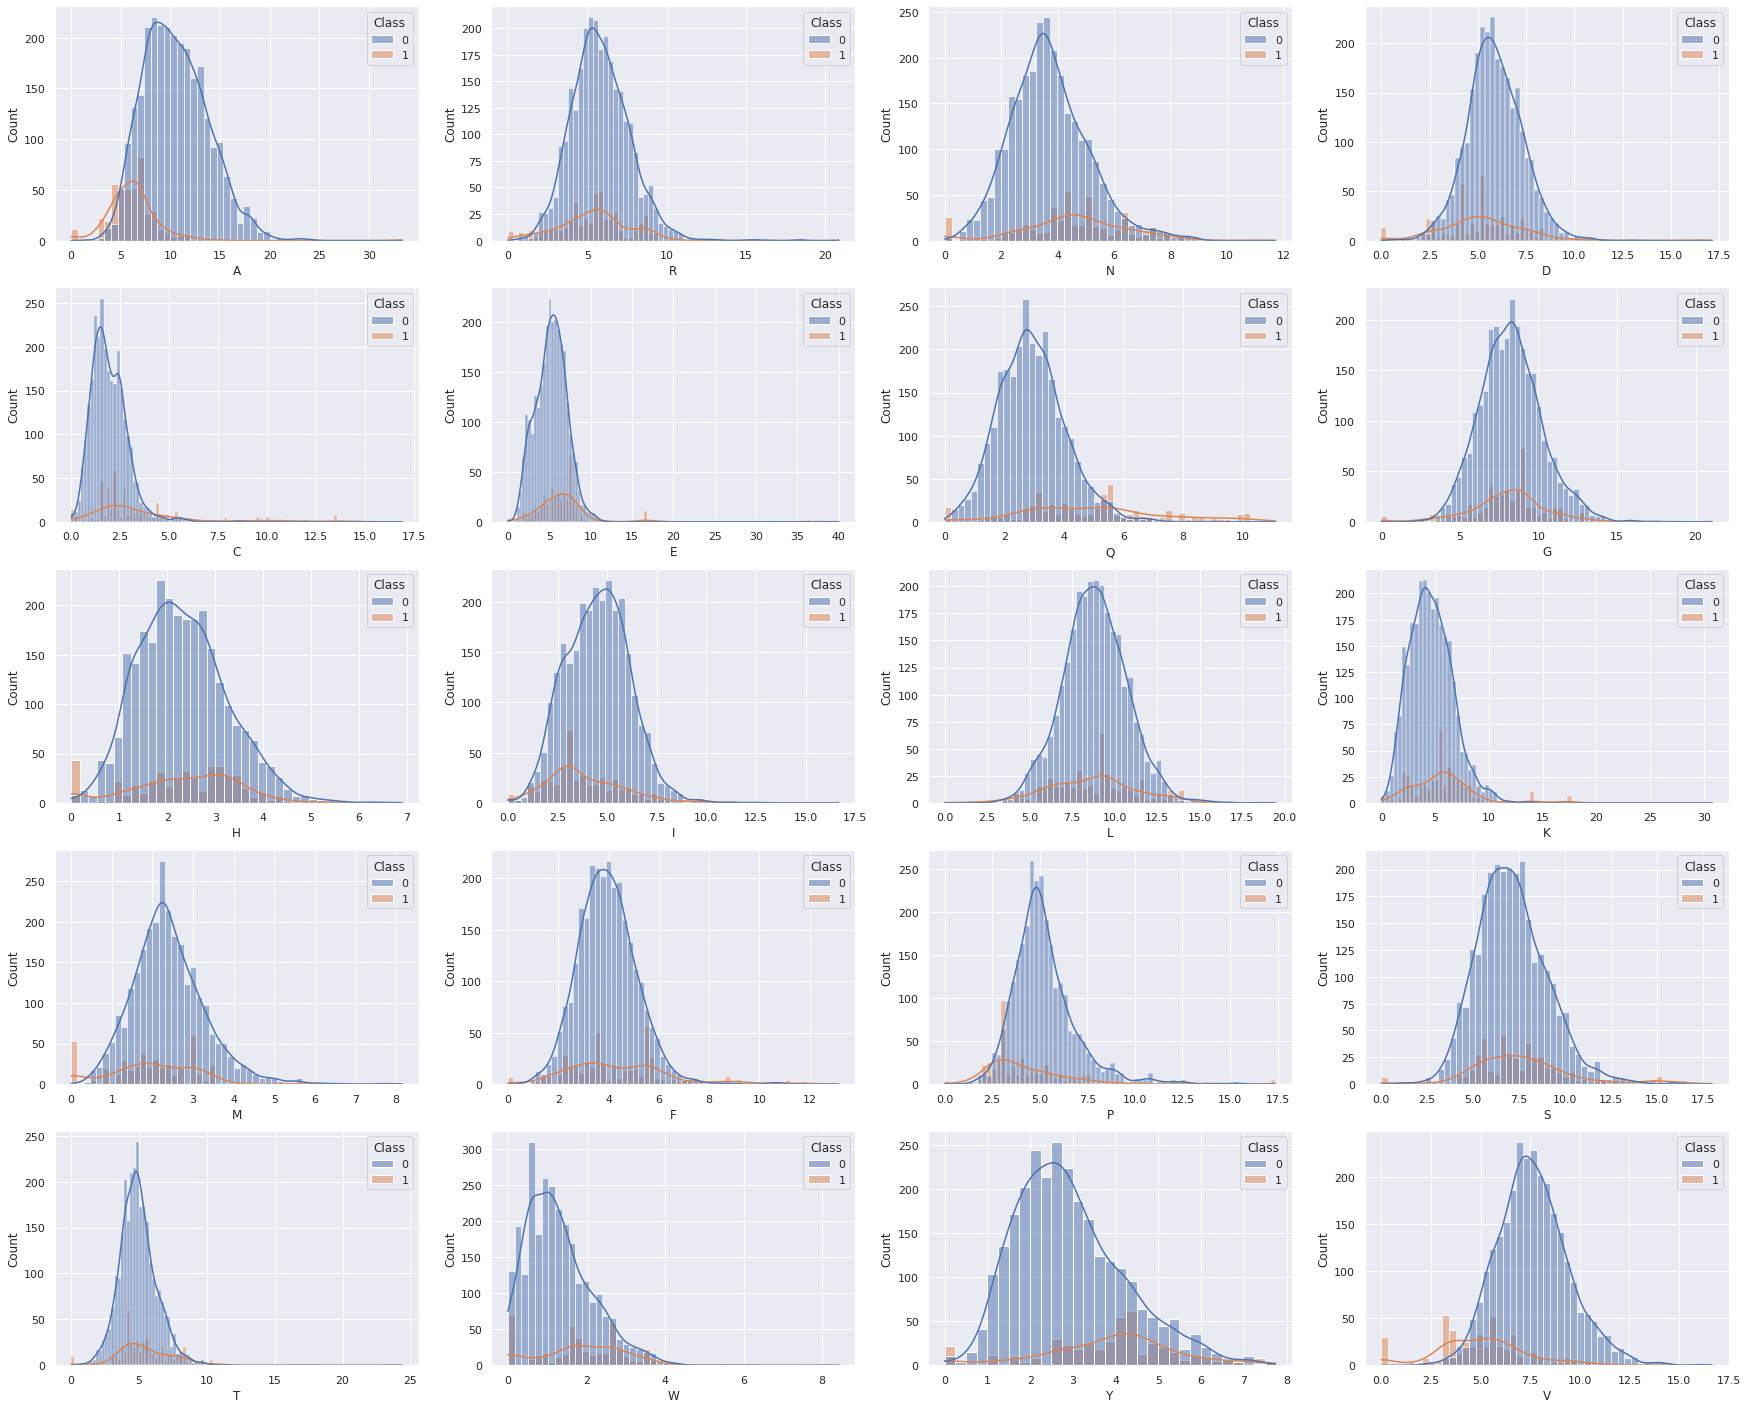

In [253]:
# Distribution of AAC features
AACFeatures = featureNames['AAC']
length = len(AACFeatures)
print('Number of features : ',length)
print()

ax = []
for i in range(0,5):
    for j in range(0,4):
        ax.append([i,j])

fig, axes = plt.subplots(5,4,figsize=(30,25))
for i in range(length):
  x,y = ax[i]
  sns.histplot(peptideDf, x=AACFeatures[i], hue='Class', ax=axes[x,y], kde=True)
plt.show()

**Figure 6 - Histogram of AAC features for both classes**

*Observation*
- Most of the AAC features are distributed normally.
- Also, for most features, the distributions are similar and equally centered except A, I, P, Y, V where we can see clear distinction.

Number of features :  400



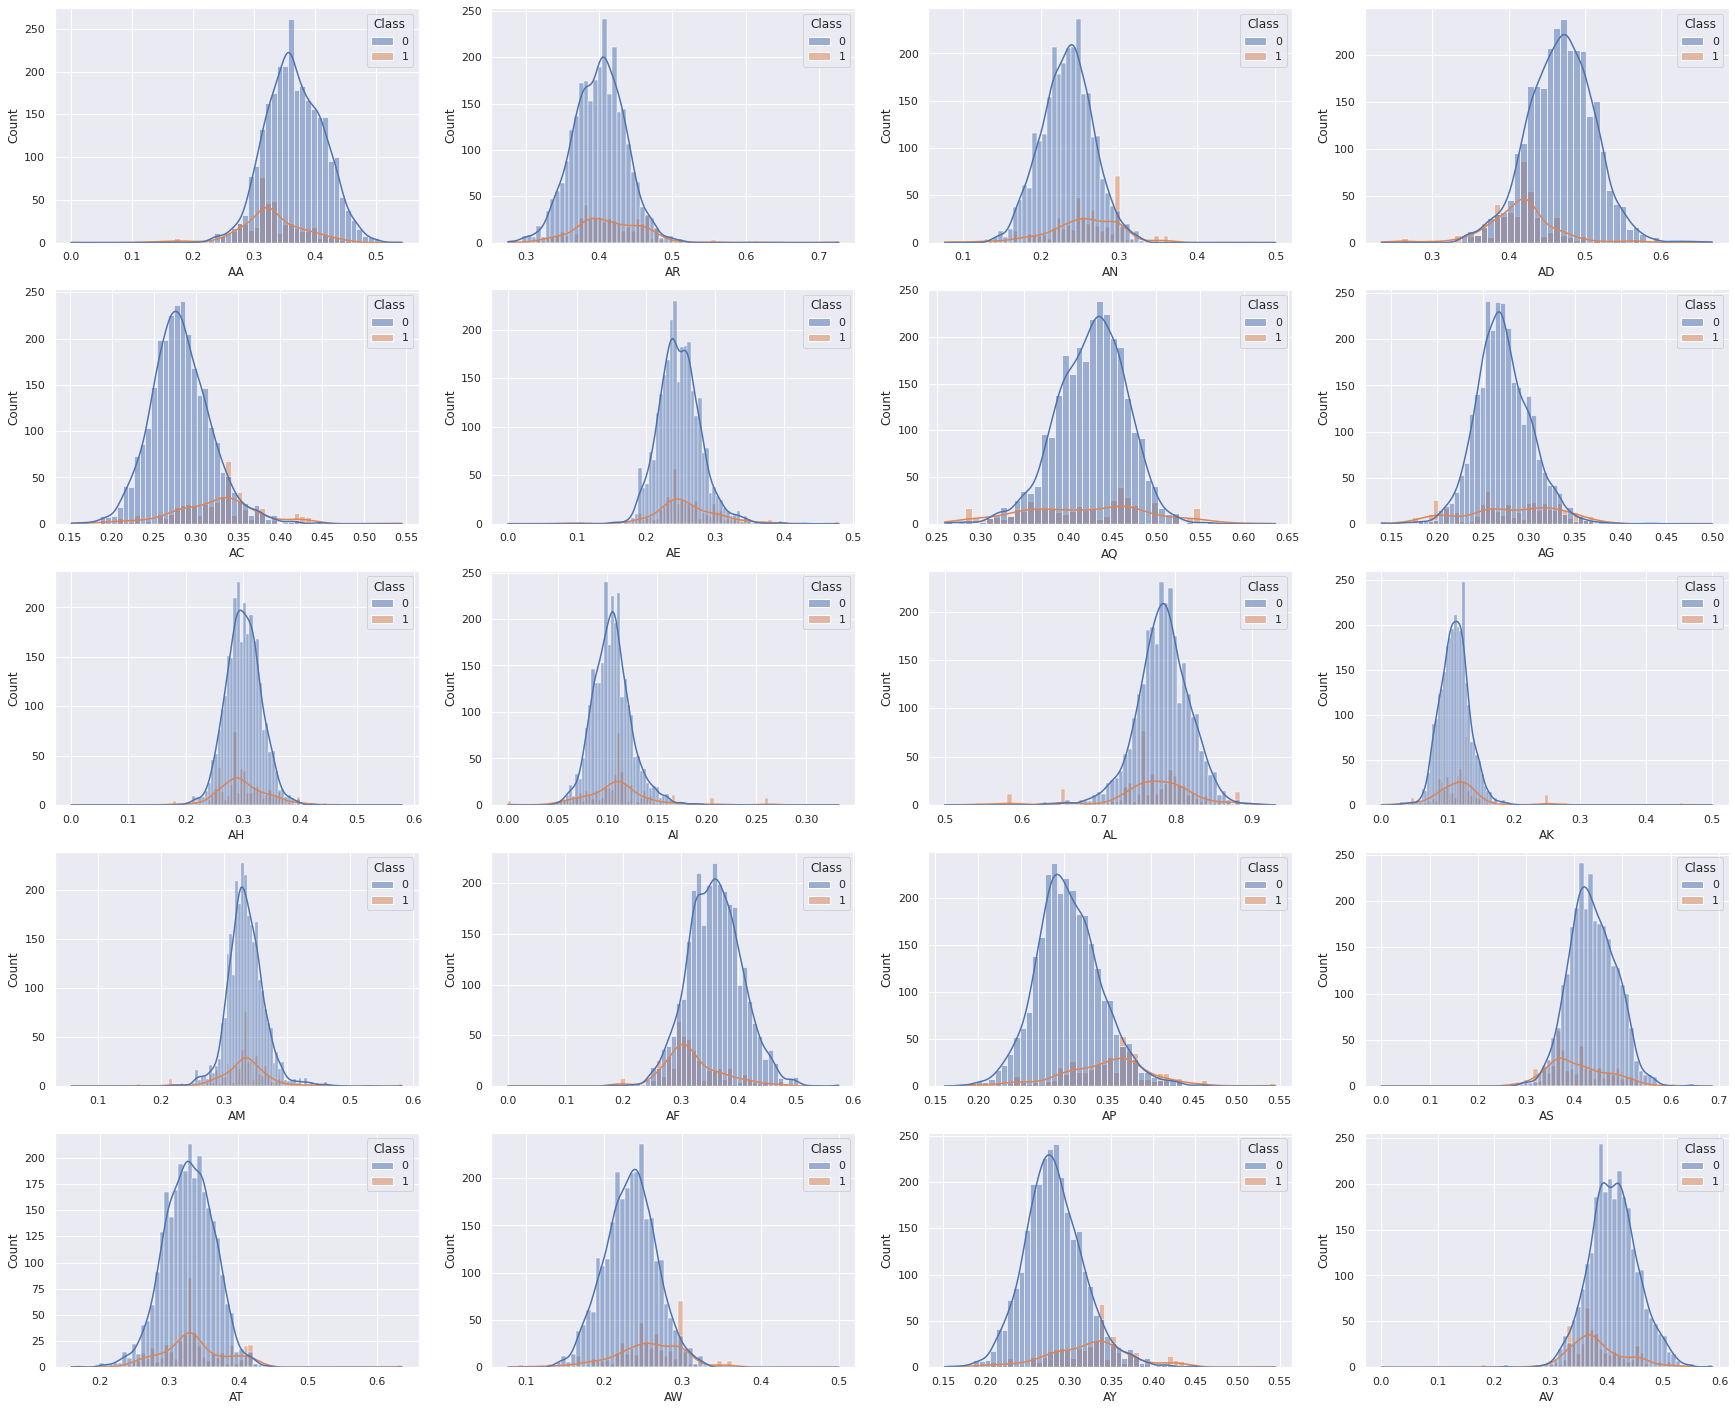

In [254]:
# Distribution of few DPC features
DPCFeatures = featureNames['DPC']
length = len(DPCFeatures)
print('Number of features : ',length)
print()

ax = []
for i in range(0,5):
    for j in range(0,4):
        ax.append([i,j])

fig, axes = plt.subplots(5,4,figsize=(30,25))
for i in range(len(ax)):
  x,y = ax[i]
  sns.histplot(peptideDf, x=DPCFeatures[i], hue='Class', ax=axes[x,y], kde=True)
plt.show()

**Figure 7 - Histogram of DPC features for both classes**

*Observation*
- Most of the DPC features are distributed normally.
- Also, for most features, the distributions are similar and equally centered except AD, AC, AF, AP, AY, AV where we can see clear distinction.

Number of features :  147



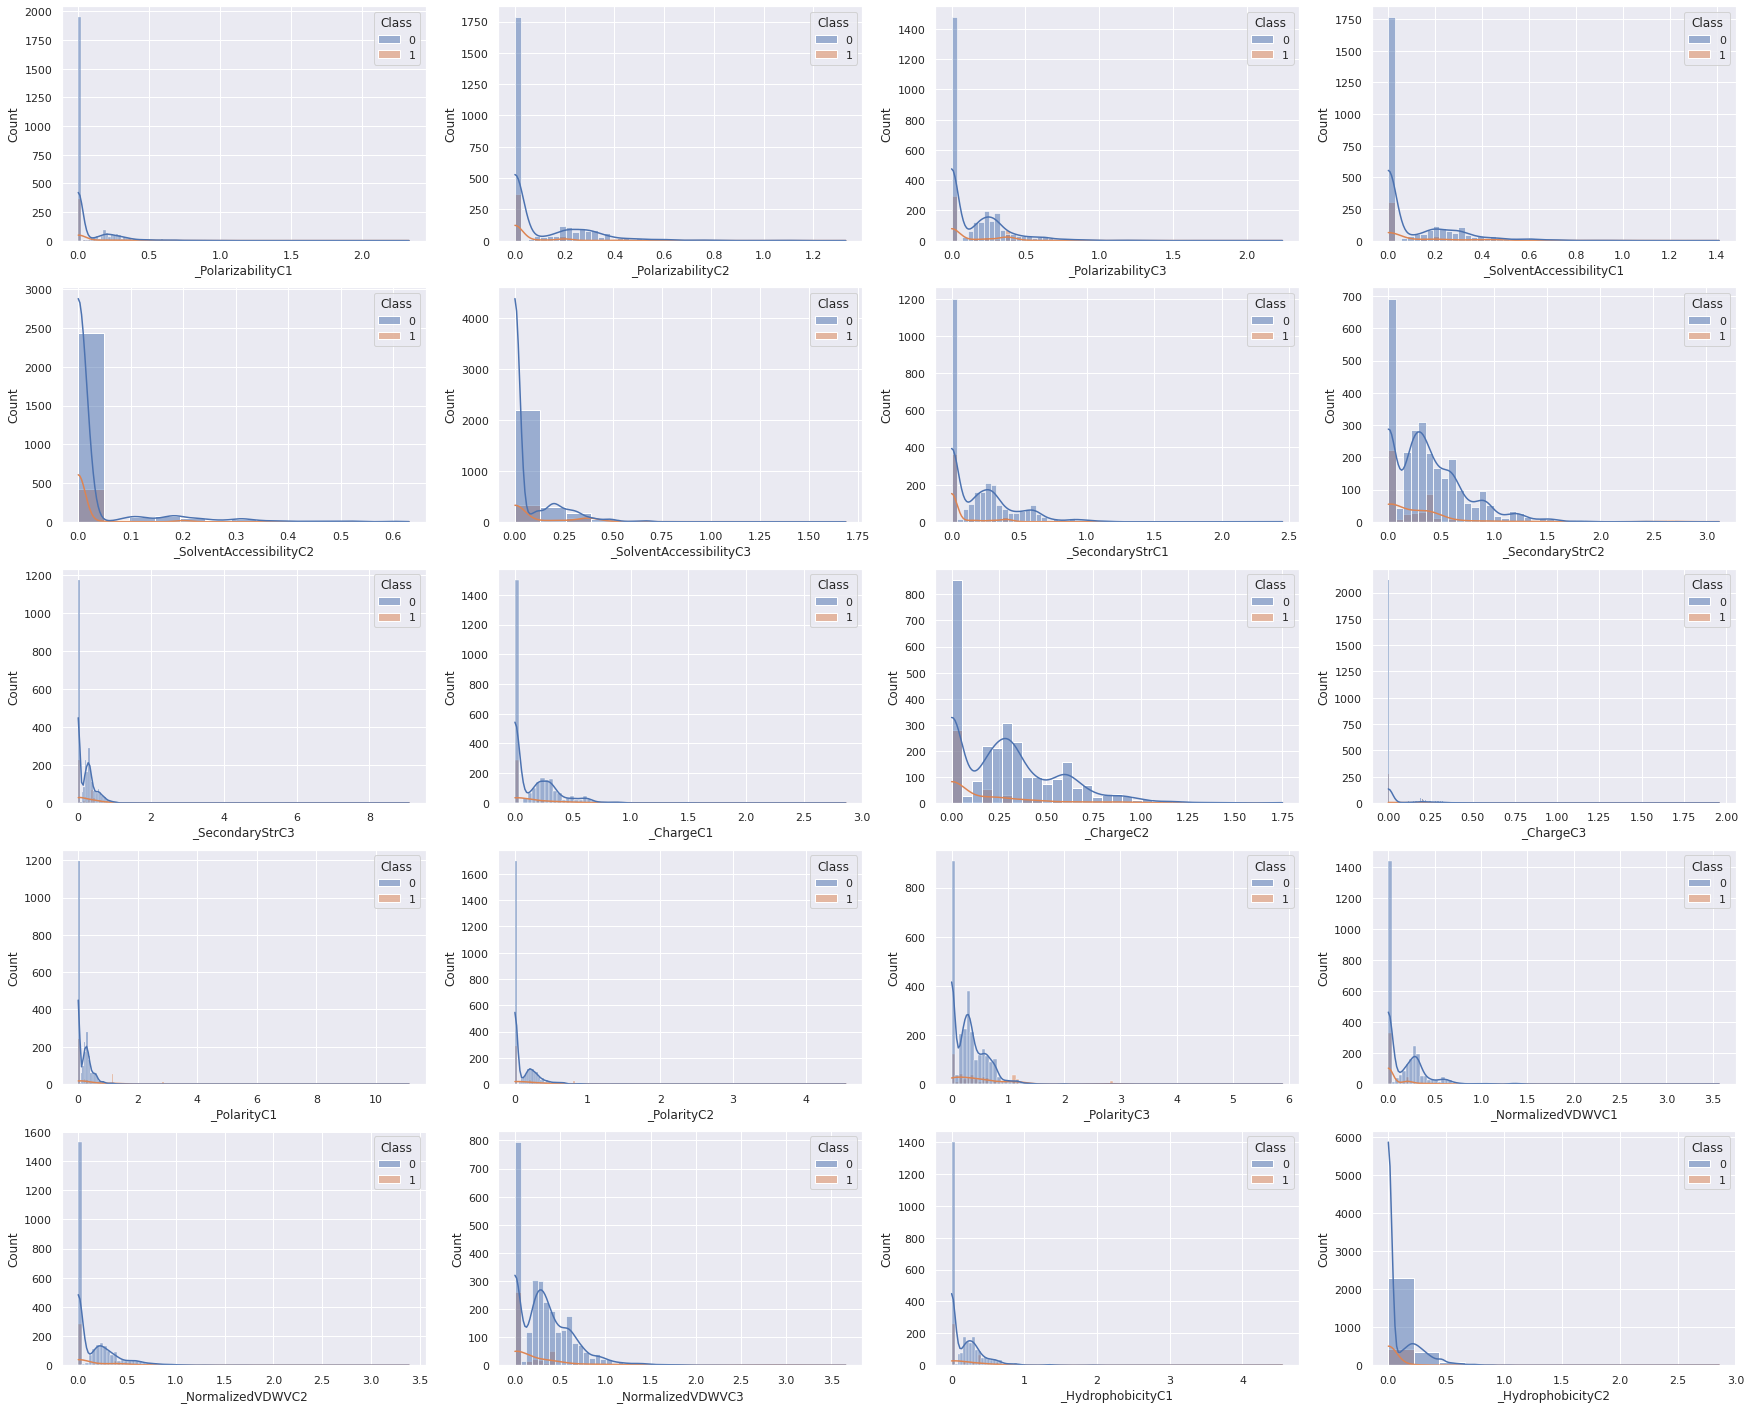

In [255]:
# Distribution of AAC features
CTDFeatures = featureNames['CTD']
length = len(CTDFeatures)
print('Number of features : ',length)
print()

ax = []
for i in range(0,5):
    for j in range(0,4):
        ax.append([i,j])

fig, axes = plt.subplots(5,4,figsize=(30,25))
for i in range(len(ax)):
  x,y = ax[i]
  sns.histplot(peptideDf, x=CTDFeatures[i], hue='Class', ax=axes[x,y], kde=True)
plt.show()

**Figure 8 - Histogram of DPC features for both classes**

*Observation*
- Most of the AAC features are right skewed.
- Also, we can see, a large number of peptides has zero values for these features.

## Percentage Composition

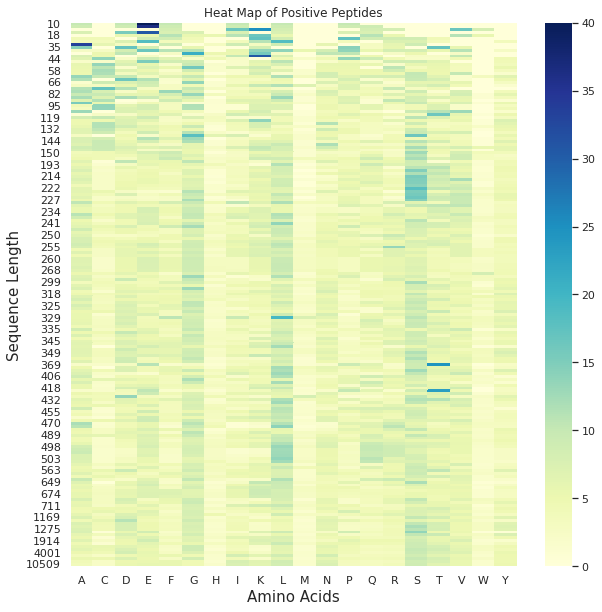

In [256]:
import warnings
warnings.filterwarnings("ignore")

# Transform to visualize occurances of each peptide in sequences
aa_seq = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
AAdf = positiveDf[aa_seq]
AAdf['SeqLength'] = positiveDf['SeqLength']
AAdf[aa_seq].div(AAdf.SeqLength, axis=0)
AAdf = AAdf.sort_values('SeqLength')

aa_seq_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])
aa_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])

for i in aa_seq:
    aa_seq_df['SeqLength'] = AAdf['SeqLength']
    aa_seq_df['amino_acid'] = i
    aa_seq_df['Composition'] = AAdf[i]
    aa_df = pd.concat([aa_df,aa_seq_df],ignore_index=True)

aa_df = aa_df.sort_values('Composition', ascending=False).drop_duplicates(['SeqLength','amino_acid'])

# Create long format
seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']
df = pd.DataFrame({'feature': feature, 'seq': seq, 'value': value })

dfe = df[df['feature'] == 'E']
dfe.sort_values('seq').head(10)

seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']

# Turn long format into a wide format
df_wide = df.pivot_table( index='seq', columns='feature', values='value')

# plot it
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_wide, cmap="YlGnBu")
plt.title('Heat Map of Positive Peptides')
plt.ylabel('Sequence Length',fontsize=15)
plt.xlabel('Amino Acids',fontsize=15)
plt.show()

**Figure 9 - Composition of each Amino Acid in positive class**

*Observation*
- The percentage of amino acid L and S occurs more in Positive Peptides.

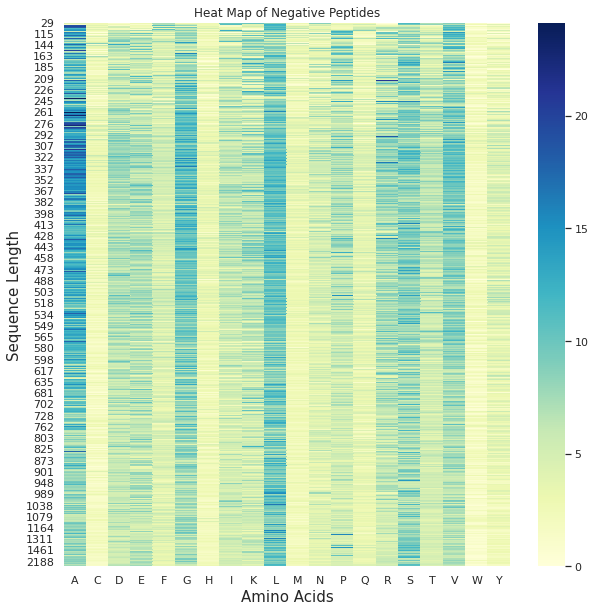

In [257]:
import warnings
warnings.filterwarnings("ignore")

# Transform to visualize occurances of each peptide in sequences
aa_seq = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
AAdf = negativeDf[aa_seq]
AAdf['SeqLength'] = negativeDf['SeqLength']
AAdf[aa_seq].div(AAdf.SeqLength, axis=0)
AAdf = AAdf.sort_values('SeqLength')

aa_seq_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])
aa_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])

for i in aa_seq:
    aa_seq_df['SeqLength'] = AAdf['SeqLength']
    aa_seq_df['amino_acid'] = i
    aa_seq_df['Composition'] = AAdf[i]
    aa_df = pd.concat([aa_df,aa_seq_df],ignore_index=True)

aa_df = aa_df.sort_values('Composition', ascending=False).drop_duplicates(['SeqLength','amino_acid'])

# Create long format
seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']
df = pd.DataFrame({'feature': feature, 'seq': seq, 'value': value })

dfe = df[df['feature'] == 'E']
dfe.sort_values('seq').head(10)

seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']

# Turn long format into a wide format
df_wide = df.pivot_table( index='seq', columns='feature', values='value')

# plot it
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_wide, cmap="YlGnBu")
plt.title('Heat Map of Negative Peptides')
plt.ylabel('Sequence Length',fontsize=15)
plt.xlabel('Amino Acids',fontsize=15)
plt.show()

**Figure 10 - Composition of each Amino Acid in negative class**

*Observation*
- The percentage of amino acids A,G,V along with L and S are more in Negative Peptides.

## PCA

In [260]:
y = peptideDf['Class']
X = peptideDf.drop(['Name','Seq','Class'],axis=1)

# Printing the shape of the dataframe
print('Shape of X: ',X.shape[0],X.shape[1])
print('Shape of y: ',y.shape[0])

Shape of X:  3194 573
Shape of y:  3194


In [261]:
scaler = MinMaxScaler()
scaler.fit(X)
X_mms =  pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

In [262]:
pca = PCA()
pca.fit(X_mms)

pca_df = pd.DataFrame({'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)})
pca_df = pca_df.transpose()
pca_df.columns = ['PC{}'.format(i) for i in range(1, len(pca_df.columns) + 1)]
pd.set_option('display.max_columns',None)
pca_df.round(4)

PC1    PC2     PC3    PC4     PC5     PC6     PC7  \
Cumulative proportion  0.0562  0.089  0.1197  0.147  0.1691  0.1878  0.2058   

                          PC8     PC9    PC10    PC11   PC12    PC13    PC14  \
Cumulative proportion  0.2218  0.2364  0.2501  0.2622  0.274  0.2852  0.2959   

                         PC15    PC16    PC17    PC18   PC19    PC20    PC21  \
Cumulative proportion  0.3062  0.3158  0.3254  0.3344  0.343  0.3515  0.3598   

                         PC22    PC23    PC24    PC25    PC26    PC27    PC28  \
Cumulative proportion  0.3679  0.3755  0.3828  0.3901  0.3971  0.4039  0.4106   

                         PC29    PC30  PC31    PC32   PC33    PC34    PC35  \
Cumulative proportion  0.4172  0.4237  0.43  0.4361  0.442  0.4478  0.4535   

                         PC36    PC37    PC38    PC39   PC40    PC41    PC42  \
Cumulative proportion  0.4592  0.4648  0.4704  0.4757  0.481  0.4862  0.4914   

                         PC43    PC44    PC45    PC46    PC47    PC48    PC49  \
Cumulative proportion  0.4965  0.5015  0.5064  0.5113  0.5161  0.5208  0.5255   

                         PC50    PC51    PC52    PC53    PC54    PC55    PC56  \
Cumulative proportion  0.5301  0.5346  0.5391  0.5435  0.5478  0.5521  0.5564   

                         PC57    PC58    PC59    PC60    PC61    PC62    PC63  \
Cumulative proportion  0.5605  0.5646  0.5686  0.5727  0.5766  0.5805  0.5844   

                         PC64   PC65    PC66    PC67    PC68    PC69    PC70  \
Cumulative proportion  0.5882  0.592  0.5958  0.5995  0.6032  0.6068  0.6104   

                         PC71    PC72    PC73    PC74    PC75    PC76    PC77  \
Cumulative proportion  0.6139  0.6174  0.6209  0.6244  0.6277  0.6311  0.6344   

                         PC78   PC79    PC80    PC81    PC82    PC83    PC84  \
Cumulative proportion  0.6377  0.641  0.6442  0.6473  0.6505  0.6536  0.6568   

                         PC85    PC86    PC87    PC88    PC89    PC90    PC91  \
Cumulative proportion  0.6598  0.6628  0.6659  0.6689  0.6718  0.6747  0.6775   

                         PC92    PC93   PC94    PC95    PC96    PC97   PC98  \
Cumulative proportion  0.6804  0.6832  0.686  0.6888  0.6916  0.6943  0.697   

                         PC99   PC100   PC101   PC102   PC103  PC104   PC105  \
Cumulative proportion  0.6997  0.7024  0.7051  0.7077  0.7103  0.713  0.7155   

                        PC106   PC107   PC108   PC109   PC110   PC111  PC112  \
Cumulative proportion  0.7181  0.7206  0.7231  0.7256  0.7281  0.7305  0.733   

                        PC113   PC114   PC115   PC116   PC117  PC118   PC119  \
Cumulative proportion  0.7354  0.7377  0.7401  0.7424  0.7447  0.747  0.7493   

                        PC120   PC121  PC122   PC123   PC124   PC125   PC126  \
Cumulative proportion  0.7516  0.7538  0.756  0.7582  0.7604  0.7625  0.7647   

                        PC127   PC128  PC129   PC130   PC131   PC132   PC133  \
Cumulative proportion  0.7668  0.7689  0.771  0.7731  0.7752  0.7772  0.7792   

                        PC134   PC135   PC136   PC137   PC138   PC139  PC140  \
Cumulative proportion  0.7813  0.7832  0.7852  0.7872  0.7892  0.7911  0.793   

                        PC141   PC142   PC143   PC144   PC145   PC146   PC147  \
Cumulative proportion  0.7949  0.7968  0.7987  0.8006  0.8024  0.8043  0.8061   

                        PC148   PC149   PC150   PC151   PC152   PC153   PC154  \
Cumulative proportion  0.8079  0.8097  0.8114  0.8132  0.8149  0.8167  0.8184   

                        PC155   PC156   PC157   PC158   PC159   PC160   PC161  \
Cumulative proportion  0.8201  0.8218  0.8235  0.8251  0.8268  0.8285  0.8301   

                        PC162   PC163  PC164   PC165   PC166   PC167   PC168  \
Cumulative proportion  0.8317  0.8334  0.835  0.8365  0.8381  0.8397  0.8412   

                        PC169   PC170   PC171   PC172   PC173   PC174   PC175  \
Cumulative proportion  0.8427  0.8442  0.8457  0.8472  0.8487  0.8502  

PC274 gives 95% cumulative proportion

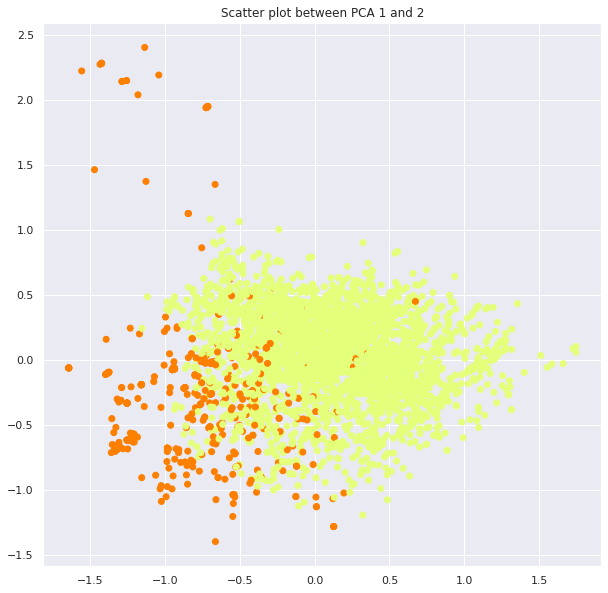

In [265]:
Xpca = pca.fit_transform(X_mms)
plt.scatter(Xpca[:,0], Xpca[:,1], c=y, cmap='Wistia')
plt.title('Scatter plot between PCA 1 and 2')
plt.show()

**Figure 11 - Scatter plot between PCA 1 and 2**

*Observation*
- No clear linear separation between both the classes.
- Non-linear model might work better.